# Подключаем Spark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [ ]:
!pip install findspark
import findspark
findspark.init()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загружаем датасет

In [ ]:
schema = StructType([
    StructField('age',IntegerType(),True),
    StructField('workclass',StringType(),True),
    StructField('fnlwgt',DoubleType(),True),
    StructField('education', StringType(), True),
    StructField('education-num', DoubleType(), True),
    StructField('marital-status', StringType(), True),
    StructField('occupation',StringType(),True),
    StructField('relationship',StringType(),True),
    StructField('race',StringType(),True),
    StructField('sex', StringType(), True),
    StructField('capital-gain', DoubleType(), True),
    StructField('capital-loss', DoubleType(), True),
    StructField('hours-per-week', DoubleType(), True),
    StructField('native-country', StringType(), True),
    StructField('50k', StringType(), True)
  ])

In [ ]:
train = spark.read.format("csv") \
      .option('delimiter', ', ') \
      .option("header", False) \
      .schema(schema) \
      .load('/content/drive/MyDrive/Colab/adult.data')

test = spark.read.format("csv") \
      .option('delimiter', ', ') \
      .option("header", False) \
      .schema(schema) \
      .load('/content/drive/MyDrive/Colab/adult.test')


In [ ]:
test.show(5)

+----+---------+--------+------------+-------------+------------------+-----------------+------------+-----+----+------------+------------+--------------+--------------+------+
| age|workclass|  fnlwgt|   education|education-num|    marital-status|       occupation|relationship| race| sex|capital-gain|capital-loss|hours-per-week|native-country|   50k|
+----+---------+--------+------------+-------------+------------------+-----------------+------------+-----+----+------------+------------+--------------+--------------+------+
|null|     null|    null|        null|         null|              null|             null|        null| null|null|        null|        null|          null|          null|  null|
|  25|  Private|226802.0|        11th|          7.0|     Never-married|Machine-op-inspct|   Own-child|Black|Male|         0.0|         0.0|          40.0| United-States|<=50K.|
|  38|  Private| 89814.0|     HS-grad|          9.0|Married-civ-spouse|  Farming-fishing|     Husband|White|Male|  

In [ ]:
import pyspark.sql.functions as F
#test.select(F.translate('50k', '>50K. ', '>50K ').alias('50k'))
test = test.withColumn('50k', F.regexp_replace('50k', '>50K.', '>50K'))
test = test.withColumn('50k', F.regexp_replace('50k', '<=50K.', '<=50K'))

In [ ]:
from pyspark.sql.functions import col
test.show(5)

+----+---------+--------+------------+-------------+------------------+-----------------+------------+-----+----+------------+------------+--------------+--------------+-----+
| age|workclass|  fnlwgt|   education|education-num|    marital-status|       occupation|relationship| race| sex|capital-gain|capital-loss|hours-per-week|native-country|  50k|
+----+---------+--------+------------+-------------+------------------+-----------------+------------+-----+----+------------+------------+--------------+--------------+-----+
|null|     null|    null|        null|         null|              null|             null|        null| null|null|        null|        null|          null|          null| null|
|  25|  Private|226802.0|        11th|          7.0|     Never-married|Machine-op-inspct|   Own-child|Black|Male|         0.0|         0.0|          40.0| United-States|<=50K|
|  38|  Private| 89814.0|     HS-grad|          9.0|Married-civ-spouse|  Farming-fishing|     Husband|White|Male|       

In [ ]:
data = train.union(test)

In [ ]:
data.count(), len(data.columns)

(48843, 15)

In [ ]:
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: double (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: double (nullable = true)
 |-- capital-loss: double (nullable = true)
 |-- hours-per-week: double (nullable = true)
 |-- native-country: string (nullable = true)
 |-- 50k: string (nullable = true)



# Предобработка данных

## Удаление пропусков

In [ ]:
data.describe().show()

+-------+------------------+-----------+------------------+------------+------------------+--------------+----------------+------------+------------------+------+------------------+-----------------+------------------+--------------+-----+
|summary|               age|  workclass|            fnlwgt|   education|     education-num|marital-status|      occupation|relationship|              race|   sex|      capital-gain|     capital-loss|    hours-per-week|native-country|  50k|
+-------+------------------+-----------+------------------+------------+------------------+--------------+----------------+------------+------------------+------+------------------+-----------------+------------------+--------------+-----+
|  count|             48842|      48842|             48842|       48842|             48842|         48842|           48842|       48842|             48842| 48842|             48842|            48842|             48842|         48842|48842|
|   mean| 38.64358543876172|       null|

In [ ]:
data.filter(data.workclass == '?').show(5)

+---+---------+--------+------------+-------------+--------------------+----------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
|age|workclass|  fnlwgt|   education|education-num|      marital-status|occupation| relationship|              race|   sex|capital-gain|capital-loss|hours-per-week|native-country|  50k|
+---+---------+--------+------------+-------------+--------------------+----------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
| 54|        ?|180211.0|Some-college|         10.0|  Married-civ-spouse|         ?|      Husband|Asian-Pac-Islander|  Male|         0.0|         0.0|          60.0|         South| >50K|
| 32|        ?|293936.0|     7th-8th|          4.0|Married-spouse-ab...|         ?|Not-in-family|             White|  Male|         0.0|         0.0|          40.0|             ?|<=50K|
| 25|        ?|200681.0|Some-college|         10.0|       Never-marrie

In [ ]:
data.filter(data.workclass == '?').show(5)

+---+---------+--------+------------+-------------+--------------------+----------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
|age|workclass|  fnlwgt|   education|education-num|      marital-status|occupation| relationship|              race|   sex|capital-gain|capital-loss|hours-per-week|native-country|  50k|
+---+---------+--------+------------+-------------+--------------------+----------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
| 54|        ?|180211.0|Some-college|         10.0|  Married-civ-spouse|         ?|      Husband|Asian-Pac-Islander|  Male|         0.0|         0.0|          60.0|         South| >50K|
| 32|        ?|293936.0|     7th-8th|          4.0|Married-spouse-ab...|         ?|Not-in-family|             White|  Male|         0.0|         0.0|          40.0|             ?|<=50K|
| 25|        ?|200681.0|Some-college|         10.0|       Never-marrie

In [ ]:
from pyspark.sql.functions import col
data_without_misses = data.filter(col("workclass") != '?').filter(col("occupation") != '?').filter(col("native-country") != '?')

In [ ]:
data_without_misses.show(5)

+---+----------------+--------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+-----+
|age|       workclass|  fnlwgt|education|education-num|    marital-status|       occupation| relationship| race|   sex|capital-gain|capital-loss|hours-per-week|native-country|  50k|
+---+----------------+--------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+-----+
| 39|       State-gov| 77516.0|Bachelors|         13.0|     Never-married|     Adm-clerical|Not-in-family|White|  Male|      2174.0|         0.0|          40.0| United-States|<=50K|
| 50|Self-emp-not-inc| 83311.0|Bachelors|         13.0|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|         0.0|         0.0|          13.0| United-States|<=50K|
| 38|         Private|215646.0|  HS-grad|          9.0|          Divorced|Handlers-cleaner

In [ ]:
data_without_misses.count(), len(data_without_misses.columns)

(45222, 15)

## Удаление дубликатов

In [ ]:
df2 = data_without_misses.dropDuplicates()
df2.show(5, truncate=False)
print(str(df2.count()))

+---+---------+--------+------------+-------------+------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
|age|workclass|fnlwgt  |education   |education-num|marital-status    |occupation       |relationship |race              |sex   |capital-gain|capital-loss|hours-per-week|native-country|50k  |
+---+---------+--------+------------+-------------+------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
|30 |Private  |194901.0|11th        |7.0          |Never-married     |Handlers-cleaners|Own-child    |White             |Male  |0.0         |0.0         |40.0          |United-States |<=50K|
|19 |Private  |316868.0|Some-college|10.0         |Never-married     |Other-service    |Own-child    |White             |Male  |0.0         |0.0         |30.0          |Mexico        |<=50K|
|52 |Private  |190762.0|1st-4th     |2.0     

In [ ]:
df = df2.toPandas()

## Обработка неинформативных признаков


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,45175.0,38.556170,13.215349,17.0,28.0,37.0,47.0,90.0
fnlwgt,45175.0,189738.798450,105652.436515,13492.0,117392.5,178312.0,237903.0,1490400.0
education-num,45175.0,10.119314,2.551740,1.0,9.0,10.0,13.0,16.0
capital-gain,45175.0,1102.576270,7510.249876,0.0,0.0,0.0,0.0,99999.0
capital-loss,45175.0,88.687593,405.156611,0.0,0.0,0.0,0.0,4356.0
hours-per-week,45175.0,40.942512,12.007730,1.0,40.0,40.0,45.0,99.0


In [ ]:
num_rows = len(df.index)
low_information_cols = []

for col_ in df.columns:
    cnts = df[col_].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]

    if top_pct > 0.90:
        low_information_cols.append(col_)
        print('{0}: {1:.5f}%'.format(col_, top_pct*100))
        print(cnts.iloc[:5])

print(low_information_cols)

capital-gain: 91.61040%
0.0        41385
15024.0      498
7688.0       391
7298.0       351
99999.0      229
Name: capital-gain, dtype: int64
capital-loss: 95.26287%
0.0       43035
1902.0      294
1977.0      246
1887.0      228
2415.0       68
Name: capital-loss, dtype: int64
native-country: 91.32485%
United-States    41256
Mexico             895
Philippines        282
Germany            193
Puerto-Rico        175
Name: native-country, dtype: int64
['capital-gain', 'capital-loss', 'native-country']


Видим, что у ттрех признаков не менее 90% одинаковых значений. Поэтому удалим их из датасет, посколько они неинформативные.

In [ ]:
df.drop(columns = low_information_cols, axis = 1, inplace=True)

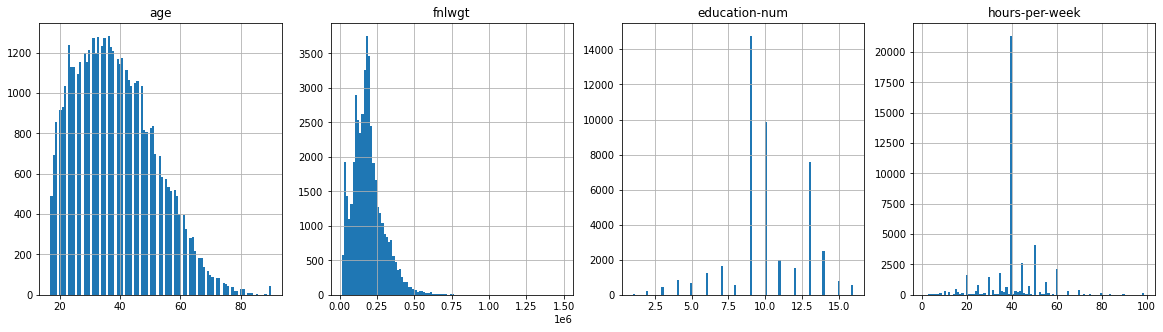

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
for i, col_ in enumerate(['age','fnlwgt', 'education-num', 'hours-per-week']):
  plt.subplot(1, 4, i+1)
  df[col_].hist(bins=100)
  plt.title(col_)
plt.show()

In [ ]:
df2 = spark.createDataFrame(df)

## Данные сильно несбалансированы

In [ ]:
df2.groupBy("50k").count().show()

+-----+-----+
|  50k|count|
+-----+-----+
|<=50K|33973|
| >50K|11202|
+-----+-----+



In [ ]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="50k", outputCol="label")
data = indexer.fit(df2).transform(df2)

In [ ]:
from pyspark.sql.functions import col
data = data.drop(col('50k'))

In [ ]:
data.printSchema()

root
 |-- age: long (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: double (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- hours-per-week: double (nullable = true)
 |-- label: double (nullable = false)



In [ ]:
import numpy as np
from pyspark.sql.functions import col
df1 = data.filter(col("label") == 1)
df0 = data.filter(col("label") == 0)
ratio = int(df0.count() / df1.count())
print(ratio)

3


In [ ]:
from pyspark.sql.functions import col, explode, array, lit
a = range(ratio)
oversampled_df = df1.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
combined_df = df0.unionAll(oversampled_df)
combined_df.show(5)

+---+---------+--------+------------+-------------+------------------+-----------------+-------------+------------------+------+--------------+-----+
|age|workclass|  fnlwgt|   education|education-num|    marital-status|       occupation| relationship|              race|   sex|hours-per-week|label|
+---+---------+--------+------------+-------------+------------------+-----------------+-------------+------------------+------+--------------+-----+
| 30|  Private|194901.0|        11th|          7.0|     Never-married|Handlers-cleaners|    Own-child|             White|  Male|          40.0|  0.0|
| 19|  Private|316868.0|Some-college|         10.0|     Never-married|    Other-service|    Own-child|             White|  Male|          30.0|  0.0|
| 52|  Private|190762.0|     1st-4th|          2.0|Married-civ-spouse|Machine-op-inspct|      Husband|             White|  Male|          40.0|  0.0|
| 25|  Private|267044.0|Some-college|         10.0|     Never-married|     Adm-clerical|Not-in-famil

In [ ]:
combined_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|33973|
|  1.0|33606|
+-----+-----+



Теперь данные сбалансированны

## Проиндексируем строковые признаки

In [ ]:
from pyspark.ml.feature import StringIndexer

string_columns = []
for field in combined_df.schema.fields:
    if field.dataType == StringType():
      string_columns.append(field.name)

string_columns_ind = [x + '_ind' for x in string_columns]


indexer = StringIndexer(inputCols=string_columns, outputCols=string_columns_ind)

data = indexer.fit(combined_df).transform(combined_df)


## Кодируем категориальные признаки

In [ ]:
from pyspark.ml.feature import OneHotEncoder

cat_columns = [x + '_coded' for x in string_columns_ind]
encoder = OneHotEncoder(inputCols = string_columns_ind, outputCols=cat_columns)

encoded = encoder.fit(data).transform(data)

In [ ]:
encoded.show(5)

+---+---------+--------+------------+-------------+------------------+-----------------+-------------+------------------+------+--------------+-----+-------------+-------------+------------------+--------------+----------------+--------+-------+-------------------+-------------------+------------------------+--------------------+----------------------+--------------+-------------+
|age|workclass|  fnlwgt|   education|education-num|    marital-status|       occupation| relationship|              race|   sex|hours-per-week|label|workclass_ind|education_ind|marital-status_ind|occupation_ind|relationship_ind|race_ind|sex_ind|workclass_ind_coded|education_ind_coded|marital-status_ind_coded|occupation_ind_coded|relationship_ind_coded|race_ind_coded|sex_ind_coded|
+---+---------+--------+------------+-------------+------------------+-----------------+-------------+------------------+------+--------------+-----+-------------+-------------+------------------+--------------+----------------+----

## Преобразуем в вектор

In [ ]:
features = ['age', 'hours-per-week', 'fnlwgt', 'education-num',
            'education_ind_coded', 'marital-status_ind_coded', 'occupation_ind_coded',
            'relationship_ind_coded', 'race_ind_coded', 'sex_ind_coded', 'workclass_ind_coded'
            ]
target = 'label'
attributes = features + [target]

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=features,
                            outputCol='features')
output = assembler.transform(encoded)

In [ ]:
output.select('features').show(5, truncate=False)

+----------------------------------------------------------------------------------------+
|features                                                                                |
+----------------------------------------------------------------------------------------+
|(54,[0,1,2,3,11,20,33,40,43,47,48],[30.0,40.0,194901.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(54,[0,1,2,3,6,20,30,40,43,47,48],[19.0,30.0,316868.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(54,[0,1,2,3,18,19,31,38,43,47,48],[52.0,40.0,190762.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(54,[0,1,2,3,6,20,29,39,46,48],[25.0,20.0,267044.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0])       |
|(54,[0,1,2,3,15,23,37,41,44,48],[65.0,24.0,109351.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0])       |
+----------------------------------------------------------------------------------------+
only showing top 5 rows



## Нормализуем векторы

In [ ]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="features", outputCol="norm_features")

scaler_model = scaler.fit(output)

scaled_data = scaler_model.transform(output)
scaled_data.select("norm_features").show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------+
|norm_features                                                                                                                                   |
+------------------------------------------------------------------------------------------------------------------------------------------------+
|(54,[0,1,2,3,11,20,33,40,43,47,48],[0.1780821917808219,0.39795918367346933,0.12283026430894815,0.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                |
|(54,[0,1,2,3,6,20,30,40,43,47,48],[0.0273972602739726,0.29591836734693877,0.20541293025699636,0.6,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                 |
|(54,[0,1,2,3,18,19,31,38,43,47,48],[0.4794520547945205,0.39795918367346933,0.12002778778366695,0.06666666666666667,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(54,[0,1,2,3,6,20,29,39,46,48],[0.1095890410958904,0.19387755102040816,0.1716775858753558,0.6,1.0,1.0,1.0,1.0,1.0,1.0

# Построим несколько моделей классификаторов

## Логичтичечкая регрессия

In [ ]:
train, test = scaled_data.randomSplit([0.8, 0.2])

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='norm_features',
                        labelCol='label', maxIter = 10)
#print(lr.explainParams())
model = lr.fit(train)

In [ ]:
predictions = model.transform(test)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label')
print('Evaluation:', evaluator.evaluate(predictions))

Evaluation: 0.8875487461215633


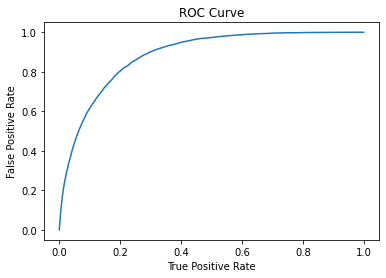

Площадь под ROC-кривой: 0.8841608073819047


In [ ]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
#help(model.summary)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Площадь под ROC-кривой: ' + str(trainingSummary.areaUnderROC))

In [ ]:
print(trainingSummary.accuracy)

0.8036307896875231


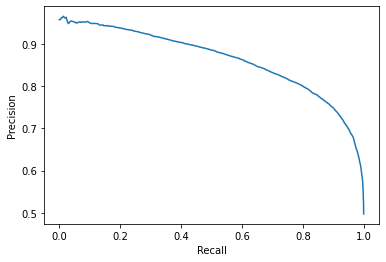

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
tp = predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()

In [ ]:
print('Матрица ошибок:')
print(tp, fp)
print(fn, tn)

Матрица ошибок:
5576 1479
1117 5259


In [ ]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F-score =',2*(precision * recall/(precision + recall)))

Accuracy = 0.8067158067158067
Precision = 0.7903614457831325
Recall = 0.833109218586583
F-score = 0.8111725341867908


In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol = 'label')
#print(dtModel.explainParams())

print("Площадь под ROC-кривой: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Площадь под ROC-кривой: 0.8875546888100105


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'norm_features', labelCol = 'label', maxDepth = 5)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
#predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(5)

In [ ]:
tp = predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()

In [ ]:
print('Матрица ошибок:')
print(tp, fp)
print(fn, tn)

Матрица ошибок:
5658 1637
1035 5101


In [ ]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F-score =',2*(precision * recall/(precision + recall)))

Accuracy = 0.8010572556027101
Precision = 0.7755997258396162
Recall = 0.845360824742268
F-score = 0.8089791249642552


## Случайный лес

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'norm_features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
#predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol = 'label')
print("Площадь под ROC-кривой: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Площадь под ROC-кривой: 0.8707478456534796


## Дерево решений с градиентным бустингом

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol = 'norm_features', labelCol = 'label', maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
#predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(5)

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol = 'label')
print("Площадь под ROC-кривой: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Площадь под ROC-кривой: 0.8894067010553195


In [ ]:
tp = predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()

In [ ]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F-score =',2*(precision * recall/(precision + recall)))

Accuracy = 0.8063435336162609
Precision = 0.7787465940054495
Recall = 0.8540265949499477
F-score = 0.8146511793629301


#Создадим Pipiline

In [ ]:
from pyspark.ml import Pipeline
stages = []
label_stringIdx = StringIndexer(inputCol="50k", outputCol="label")
stages += [label_stringIdx]

categoricalColumns = ['education', 'marital-status', 'occupation',
            'relationship', 'race', 'sex', 'workclass'
            ]
target = 'label'
attributes = features + [target]
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols = ['age', 'hours-per-week', 'fnlwgt', 'education-num']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
scaler = MinMaxScaler(inputCol="features", outputCol="norm_features")
stages +=[scaler]

In [ ]:
from pyspark.ml.classification import GBTClassifier
(train, test) = data_without_misses.randomSplit([0.8, 0.2])
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
stages += [gbt]
pipeline = Pipeline(stages=stages)

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol = 'label')
print("Площадь под ROC-кривой: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Площадь под ROC-кривой: 0.8894024436068803


In [ ]:
model = pipeline.fit(train)

predictions = model.transform(test)

In [ ]:
tp = predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()

In [ ]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F-score =',2*(precision * recall/(precision + recall)))

Accuracy = 0.8295151245551602
Precision = 0.7131195335276967
Recall = 0.5401943462897526
F-score = 0.6147273184217139
